In [1]:
import numpy as np 
from numba import njit
import random
import matplotlib.pyplot as plt 
import math

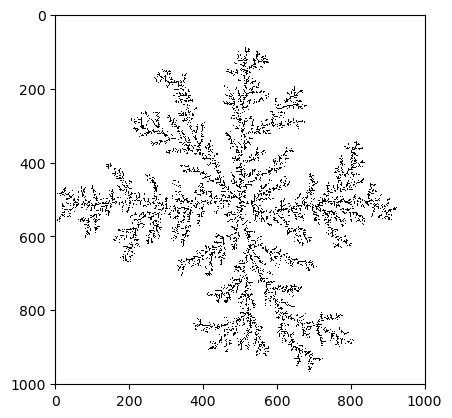

In [2]:
# Constants
GRID_SIZE = 1000
RADIUS = (GRID_SIZE // 2 ) +5# Radius of the circle
SEED = (GRID_SIZE // 2, GRID_SIZE // 2)  # Seed in the middle of the grid

# Initialize grid (plus 1 to account for 0-index)
grid = np.zeros((GRID_SIZE + 1, GRID_SIZE + 1))
grid[SEED[0], SEED[1]] = 1  # Set seed point as part of cluster



@njit # This decorator tells Numba to compile this function using the JIT (just-in-time) compiler
def particle_loop(GRID_SIZE, RADIUS, grid):
    touches_furthest_radius = False
    current_radius = 5 #spawns particles closer to where the seed is, to speed up the program. 
    while touches_furthest_radius == False: #keeps going until a particle touches the radius of the circle while being attached to the body
    # Create the particle starting from a random point on the circle
        angle = random.uniform(0, 2 * math.pi) # Random angle in radians
        particle = (int(GRID_SIZE/2 + current_radius * math.cos(angle)), int(GRID_SIZE/2 + current_radius * math.sin(angle))) #use angle and spawn point of seed (which is the middle of the grid) ...
        # ... to calculate the x and y coordinates of a new particle. Cast it to int also. 

        while True:
            # Check if particle is out of bounds (ensure it's within grid size)
            if particle[0] < 0 or particle[1] < 0 or particle[0] >= GRID_SIZE or particle[1] >= GRID_SIZE:
                break

            # Check if the particle can attach to any adjacent grid cell (touches the cluster)
            if (grid[particle[0] + 1, particle[1]] == 1 or
                grid[particle[0] - 1, particle[1]] == 1 or
                grid[particle[0], particle[1] + 1] == 1 or
                grid[particle[0], particle[1] - 1] == 1):
                grid[particle[0], particle[1]] = 1  # Attach particle to the grid

                dist_to_seed = math.sqrt((particle[0] - GRID_SIZE/2) ** 2 + (particle[1] - GRID_SIZE/2) ** 2)
                if dist_to_seed >= current_radius-1:
                    current_radius += 5 
                    if current_radius > RADIUS:
                        touches_furthest_radius = True
                    #Stop the simulation if the particle touches the radius

                break  # Once attached, stop particle movement and move to the next particle

            # Move the particle randomly until we break the loop manually
            move = np.random.randint(0, 4)  # Randomly select one of four directions
            if move == 0:
                particle = (particle[0], particle[1] + 1)  # Move up
            elif move == 1:
                particle = (particle[0] + 1, particle[1])  # Move right
            elif move == 2:
                particle = (particle[0], particle[1] - 1)  # Move down
            elif move == 3:
                particle = (particle[0] - 1, particle[1])  # Move left


particle_loop(GRID_SIZE, RADIUS, grid)
# Plot the result
plt.imshow(grid, cmap='Greys', interpolation='nearest')
plt.show()
